### Amazon Fashion Persona @qnyue

 0. Import libraries 

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 5
pd.set_option('display.max_columns', 100)
import io
import requests
import warnings
import csv
np.random.seed(27)
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats

In [ ]:
##Check your working directory
os.getcwd()

'/content'

A couple of ways reading the data: 1) from S3 2) from cluster 3) upload csv and read it here

In [ ]:
data_main = pd.read_csv('Data_Dogfood_Sales_2022.csv', encoding="ISO-8859-1")
df= data_main.loc[data_main['product_brand']=='Bezt']
df.head()

,ï»¿sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime
5,6,2022-01-01,Don't recall seeing an ad,734114023,Bezt,Bezt Adult Chicken and Brown Rice Recipe Dry D...,14.22,1,905,M,Phoenix,AZ,85099,33.2765,-112.1872,Married,College graduate,"$100,000 or more",45-54,1
15,16,2022-01-01,Sponsored Products,899788022,Bezt,"Bezt Natural Adult Wet Dog Food, 12.5-oz cans ...",31.58,1,3634,M,Santa Ana,CA,92705,33.7540,-117.7919,Married,College graduate,"$60,000 - $79,999",65+,1
20,21,2022-01-01,Sponsored Brands,237451005,Bezt,Bezt Natural Adult Small Breed Dry Dog Food,16.13,1,2190,M,Kansas City,KS,66105,39.0850,-94.6356,Single,College graduate,"$40,000 - $59,999",55-64,1
22,23,2022-01-01,Sponsored Brands,123910010,Bezt,Bezt Natural Adult Healthy Weight Chicken and ...,56.99,1,4884,F,Fresno,CA,93778,36.7464,-119.6397,Married,High school graduate,"$40,000 - $59,999",45-54,1
24,25,2022-01-01,Display/banner ad,869552045,Bezt,Bezt Natural Adult Beef and Brown Rice Dry Dog...,37.03,1,1272,M,Trenton,NJ,8695,40.2805,-74.7120,Single,Some college or trade school,"$60,000 - $79,999",65+,1


2. Create additional variables

In [ ]:
#additional varaibles
df['ad_exp'].value_counts()

Don't recall seeing an ad    557
Sponsored Brands             441
Sponsored Products           338
Display/banner ad            220
Video ad                      37
Some other type of ad          8
Name: ad_exp, dtype: int64

In [ ]:
df['ad_ind']= np.where(df['ad_exp']=="Don't recall seeing an ad", 0,1)
df['ad_ind'].value_counts()

1    1044
0     557
Name: ad_ind, dtype: int64

In [ ]:
df['marital'].value_counts()

Married                                  837
Single                                   615
Domestic partner/serious relationship    149
Name: marital, dtype: int64

In [ ]:
df['ma_ind']= np.where(df['marital']=="Single", 0,1)
df['ma_ind'].value_counts()

1    986
0    615
Name: ma_ind, dtype: int64

In [ ]:
df['education'].value_counts()

College graduate                703
Some college or trade school    344
High school graduate            309
Post graduate                   245
Name: education, dtype: int64

In [ ]:
df['edu_ind']= np.where(df['education']=="High school graduate", 0, np.where(df['education']=="Some college or trade school", 0,1))
df['edu_ind'].value_counts()


1    948
0    653
Name: edu_ind, dtype: int64

In [ ]:
df['income'].value_counts()

$100,000 or more     498
$80,000 - $99,999    262
$20,000 - $39,999    258
$40,000 - $59,999    257
$60,000 - $79,999    229
Less than $20,000     97
Name: income, dtype: int64

In [ ]:
def level(row): 
    if row['income'] == "Less than $20,000": 
        return '0'
    elif row['income'] == "$20,000 - $39,999":
        return '1'
    elif row['income'] == "$40,000 - $59,999":
        return '2'
    elif row['income'] == "$60,000 - $79,999":
        return '3'    
    elif row['income'] == "$80,000 - $99,999":
        return '4'  
    elif row['income'] == "$100,000 or more":
        return '5'  
    return 'other' 

In [ ]:
df['price_ind'] = np.where((df['price'] >= 0) & (df['price'] <= 36), 0, 
           np.where((df['price'] > 36) & (df['price'] <= 72), 1,
           np.where((df['price'] > 72) & (df['price'] <= 107), 2, df['price'])))

In [ ]:
df['income_level'] = df.apply(level, axis=1)

In [ ]:
df['income_level'].value_counts() 

5    498
4    262
1    258
2    257
3    229
0     97
Name: income_level, dtype: int64

In [ ]:
df.head()

,ï»¿sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,price_ind,income_level
5,6,2022-01-01,Don't recall seeing an ad,734114023,Bezt,Bezt Adult Chicken and Brown Rice Recipe Dry D...,14.22,1,905,M,Phoenix,AZ,85099,33.2765,-112.1872,Married,College graduate,"$100,000 or more",45-54,1,0,1,1,0.0,5
15,16,2022-01-01,Sponsored Products,899788022,Bezt,"Bezt Natural Adult Wet Dog Food, 12.5-oz cans ...",31.58,1,3634,M,Santa Ana,CA,92705,33.7540,-117.7919,Married,College graduate,"$60,000 - $79,999",65+,1,1,1,1,0.0,3
20,21,2022-01-01,Sponsored Brands,237451005,Bezt,Bezt Natural Adult Small Breed Dry Dog Food,16.13,1,2190,M,Kansas City,KS,66105,39.0850,-94.6356,Single,College graduate,"$40,000 - $59,999",55-64,1,1,0,1,0.0,2
22,23,2022-01-01,Sponsored Brands,123910010,Bezt,Bezt Natural Adult Healthy Weight Chicken and ...,56.99,1,4884,F,Fresno,CA,93778,36.7464,-119.6397,Married,High school graduate,"$40,000 - $59,999",45-54,1,1,1,0,1.0,2
24,25,2022-01-01,Display/banner ad,869552045,Bezt,Bezt Natural Adult Beef and Brown Rice Dry Dog...,37.03,1,1272,M,Trenton,NJ,8695,40.2805,-74.7120,Single,Some college or trade school,"$60,000 - $79,999",65+,1,1,0,0,1.0,3


In [ ]:
df.columns

Index(['ï»¿sale_id', 'sale_date', 'ad_exp', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'customer_id', 'gender', 'city', 'st',
       'zip', 'lat', 'lng', 'marital', 'education', 'income', 'age', 'prime',
       'ad_ind', 'ma_ind', 'edu_ind', 'price_ind', 'income_level'],
      dtype='object')

In [ ]:
df.dtypes

ï»¿sale_id         int64
sale_date         object
ad_exp            object
product_id         int64
product_brand     object
product_name      object
price            float64
qty                int64
customer_id        int64
gender            object
city              object
st                object
zip                int64
lat              float64
lng              float64
marital           object
education         object
income            object
age               object
prime              int64
ad_ind             int64
ma_ind             int64
edu_ind            int64
price_ind        float64
income_level      object
dtype: object

In [ ]:
df['income_level'] = df['income_level'].astype(int)


In [ ]:
df['product_count'] = (
    df.groupby(['customer_id'])['product_name'].transform('nunique'))

In [ ]:
df['brand_count'] = (
    df.groupby(['customer_id'])['product_brand'].transform('nunique'))

In [ ]:
df.head()

,ï»¿sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,price_ind,income_level,product_count,brand_count
5,6,2022-01-01,Don't recall seeing an ad,734114023,Bezt,Bezt Adult Chicken and Brown Rice Recipe Dry D...,14.22,1,905,M,Phoenix,AZ,85099,33.2765,-112.1872,Married,College graduate,"$100,000 or more",45-54,1,0,1,1,0.0,5,2,1
15,16,2022-01-01,Sponsored Products,899788022,Bezt,"Bezt Natural Adult Wet Dog Food, 12.5-oz cans ...",31.58,1,3634,M,Santa Ana,CA,92705,33.7540,-117.7919,Married,College graduate,"$60,000 - $79,999",65+,1,1,1,1,0.0,3,1,1
20,21,2022-01-01,Sponsored Brands,237451005,Bezt,Bezt Natural Adult Small Breed Dry Dog Food,16.13,1,2190,M,Kansas City,KS,66105,39.0850,-94.6356,Single,College graduate,"$40,000 - $59,999",55-64,1,1,0,1,0.0,2,1,1
22,23,2022-01-01,Sponsored Brands,123910010,Bezt,Bezt Natural Adult Healthy Weight Chicken and ...,56.99,1,4884,F,Fresno,CA,93778,36.7464,-119.6397,Married,High school graduate,"$40,000 - $59,999",45-54,1,1,1,0,1.0,2,1,1
24,25,2022-01-01,Display/banner ad,869552045,Bezt,Bezt Natural Adult Beef and Brown Rice Dry Dog...,37.03,1,1272,M,Trenton,NJ,8695,40.2805,-74.7120,Single,Some college or trade school,"$60,000 - $79,999",65+,1,1,0,0,1.0,3,1,1


In [ ]:
df2=df.groupby('customer_id').agg({'ad_ind':'mean','prime':'mean','ma_ind':'mean','edu_ind':'mean','income_level':'mean','product_count':'mean','brand_count':'mean', 'price_ind':'mean'  })
df2.head()

,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count,price_ind
customer_id,,,,,,,,
7,0.0,1.0,0.0,1.0,3.0,1.0,1.0,0.0
8,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9,1.0,1.0,1.0,1.0,4.0,1.0,1.0,0.0
12,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
18,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
df2.to_excel('output_bezt_clusters.xlsx')

In [ ]:
df2.reset_index(inplace=True)


In [ ]:
df2.head()

,customer_id,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count,price_ind
0,7,0.0,1.0,0.0,1.0,3.0,1.0,1.0,0.0
1,8,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,9,1.0,1.0,1.0,1.0,4.0,1.0,1.0,0.0
3,12,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
4,18,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
data = df2.drop(columns = 'customer_id')
ss = StandardScaler()
data = ss.fit_transform(data)

In [ ]:
df2.set_index('customer_id', inplace=True)

In [ ]:
df2.head(5)

,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count,price_ind
customer_id,,,,,,,,
7,0.0,1.0,0.0,1.0,3.0,1.0,1.0,0.0
8,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9,1.0,1.0,1.0,1.0,4.0,1.0,1.0,0.0
12,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
18,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


6. Run Cluster Analysis 

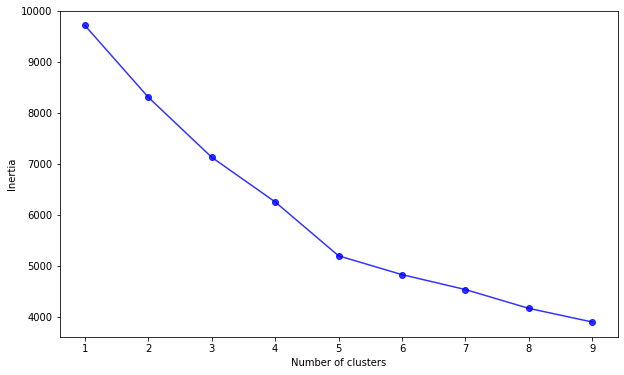

In [ ]:
##inertia is calculated as the sum of squared distance for each point to it's closest centroid

ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters = k)
    
    model.fit(data)
    inertias.append(model.inertia_)
    
plt.figure(figsize = (10,6))    
plt.plot(ks, inertias, '-o', color = 'blue', alpha = 0.8)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(data)

KMeans(n_clusters=3)

In [ ]:
# Print cluster assignments for each point
print(kmeans.labels_)

[2 2 2 ... 2 1 2]


In [ ]:
df_cluster_labels = pd.DataFrame(kmeans.labels_, index = df2.index, columns = ['cluster_label']).reset_index()

In [ ]:
print(df_cluster_labels)

      customer_id  cluster_label
0               7              2
1               8              2
2               9              2
3              12              1
4              18              2
...           ...            ...
1383         4985              2
1384         4988              1
1385         4993              2
1386         4994              1
1387         5000              2

[1388 rows x 2 columns]


##### a couple of additional metrics to evaluate cluster but it could take a while. So skip if you prefer. 

In [ ]:
df2.head()

,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count,price_ind
customer_id,,,,,,,,
7,0.0,1.0,0.0,1.0,3.0,1.0,1.0,0.0
8,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9,1.0,1.0,1.0,1.0,4.0,1.0,1.0,0.0
12,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
18,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
df_cluster_labels.head()

,customer_id,cluster_label
0,7,2
1,8,2
2,9,2
3,12,1
4,18,2


In [ ]:
df_cluster = df2.merge(df_cluster_labels, how = 'left', left_on = 'customer_id', right_on = 'customer_id')

df_cluster.head(5)

,customer_id,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count,price_ind,cluster_label
0,7,0.0,1.0,0.0,1.0,3.0,1.0,1.0,0.0,2
1,8,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2
2,9,1.0,1.0,1.0,1.0,4.0,1.0,1.0,0.0,2
3,12,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1
4,18,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2


In [ ]:
df_cluster['cluster_label'].value_counts()

2    653
1    619
0    116
Name: cluster_label, dtype: int64

In [ ]:
df_cluster_bezt= df_cluster.groupby('cluster_label').describe()
print(df_cluster_bezt)

              customer_id                                                   \
                    count         mean          std   min      25%     50%   
cluster_label                                                                
0                   116.0  2545.637931  1407.119601  32.0  1288.25  2558.0   
1                   619.0  2502.697900  1449.581886  12.0  1300.00  2461.0   
2                   653.0  2567.552833  1431.646346   7.0  1370.00  2622.0   

                               ad_ind                                          \
                   75%     max  count      mean       std  min  25%  50%  75%   
cluster_label                                                                   
0              3809.25  4925.0  116.0  0.601293  0.346969  0.0  0.5  0.5  1.0   
1              3723.00  4994.0  619.0  0.644588  0.477333  0.0  0.0  1.0  1.0   
2              3727.00  5000.0  653.0  0.664625  0.471671  0.0  0.0  1.0  1.0   

                    prime                   

In [ ]:
df_cluster_bezt.to_excel('bezt_stats.xlsx', sheet_name = 'Descriptive_stats2')

In [ ]:
mean_values = df_cluster.groupby("cluster_label").aggregate("mean")
print(mean_values)

               customer_id    ad_ind     prime    ma_ind   edu_ind  \
cluster_label                                                        
0              2726.688000  0.616000  1.000000  1.000000  0.000000   
1              2346.955000  0.995000  1.000000  1.000000  0.590000   
2              2519.820513  0.000000  1.000000  0.427350  0.000000   
3              2652.896040  0.742574  1.000000  0.000000  0.707921   
4              2545.637931  0.601293  0.827586  0.681034  0.620690   
5              2437.173410  0.806358  1.000000  1.000000  1.000000   
6              2527.074468  0.728723  0.000000  0.595745  0.531915   
7              2564.286765  0.000000  1.000000  0.713235  1.000000   
8              2590.740458  0.996183  1.000000  0.000000  0.679389   

               income_level  product_count  brand_count  price_ind  
cluster_label                                                       
0                  3.056000       1.000000          1.0   0.000000  
1                  3.1

In [ ]:
mean_values.to_excel('bezt_mean.xlsx', sheet_name = 'Descriptive_stats')

In [ ]:
df_cluster = df2.merge(df_cluster_labels, how = 'left', left_on = 'customer_id', right_on = 'customer_id')

In [ ]:
df = df.merge(df_cluster[['customer_id', 'cluster_label']], on='customer_id', how='left')

In [ ]:
counts = df.groupby('cluster_label')['product_brand'].nunique()

print(counts)

cluster_label
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
Name: product_brand, dtype: int64


In [ ]:
count = df.loc[df['cluster_label'], 'product_brand'].nunique()
#print(f"Number of distinct values in brand_count for cluster {cluster_label}: {count}")

In [ ]:
# group the DataFrame by 'cluster_label' and 'brand', and count the occurrences
count_ad = df.groupby('cluster_label')['ad_exp'].value_counts()

In [ ]:
# get the total counts for each cluster label
total_ad = df.groupby('cluster_label')['ad_exp'].count()

# divide the counts by the totals and multiply by 100 to get the percentages
percentages = count_ad.divide(total_ad, level='cluster_label') * 100

# print the result
print(percentages)

cluster_label  ad_exp                   
0              Don't recall seeing an ad     34.265734
               Sponsored Brands              27.272727
               Sponsored Products            18.881119
               Display/banner ad             12.587413
               Video ad                       6.993007
1              Sponsored Brands              39.622642
               Sponsored Products            34.433962
               Display/banner ad             20.754717
               Video ad                       3.773585
               Don't recall seeing an ad      0.943396
               Some other type of ad          0.471698
2              Don't recall seeing an ad    100.000000
3              Sponsored Brands              32.547170
               Don't recall seeing an ad     25.943396
               Sponsored Products            21.226415
               Display/banner ad             17.452830
               Video ad                       2.830189
4              Don't rec

In [ ]:
percentages.to_excel('Bezt_ad.xlsx',  sheet_name='ad_exp')

In [ ]:
# group the DataFrame by 'cluster_label' and 'brand', and count the occurrences
count_product = df.groupby('cluster_label')['product_name'].value_counts()

# get the total counts for each cluster label
total_product = df.groupby('cluster_label')['product_name'].count()

# divide the counts by the totals and multiply by 100 to get the percentages
percentages_product = count_product.divide(total_product, level='cluster_label') * 100

# print the result
print(percentages_product)

In [ ]:
percentages_product.to_excel('bezt_products.xlsx')

In [ ]:
percentages_product.to_excel('bezt.xlsx', sheet_name='popular_products')